In [10]:
import numpy as np
import random
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureType,
)

from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import yaml
import sys
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg")
from dataloader import val_dataloader
from models import unet256, unet512
import pandas as pd
import nibabel as nib

In [8]:
def showslice(img, x, y, z, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = img[:,:,z]
    clip_ax = np.rot90(clip_ax)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax= plt.subplots(1,3, figsize=(15,15))
    if is_gray:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)
    
def showSag(img, x, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        sag = plt.imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = plt.imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, fraction=0.046, pad=0.04)

def showCor(img, y, is_gray=False, clip_range=[]):
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        cor = plt.imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        cor = plt.imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(cor, fraction=0.046, pad=0.04)
    
def getSlice(data, x, y, z):
    clip_sag = data[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = data[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = data[:,:,z]
    clip_ax = np.rot90(clip_ax)
    return clip_sag, clip_cor, clip_ax

In [12]:
CONFIG_PATH = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs/Config_0327unet512.YAML"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

config = load_config(CONFIG_PATH)
config_id = "0327unet512"

In [5]:
logs_dir = os.path.join(config["log_dir"], config_id)
# loss_path = os.path.join(logs_dir, f"{config['config_id']}_loss")
# dice_path = os.path.join(logs_dir, f"{config['config_id']}_val_dice")
# val_loss_path = os.path.join(logs_dir, f"{config['config_id']}_val_loss")
loss_path = os.path.join(logs_dir, f"{config_id}_loss_20220314.1607")
train_dice_path = os.path.join(logs_dir, f"{config_id}_dice_20220314.1607")
dice_path = os.path.join(logs_dir, f"{config_id}_val_dice_20220314.1607")
val_loss_path = os.path.join(logs_dir, f"{config_id}_val_loss_20220314.1607")

def read_log(path):
    epochs= []
    metric = []
    with open(path) as f:
        for line in f:
            line = line.rstrip()
            line = line.split(",")
            epochs.append(int(line[0]))
            metric.append(float(line[1]))
    return (epochs, metric)

xloss, yloss = read_log(loss_path)
xtrain_dice, ytrain_dice = read_log(train_dice_path)
xdice, ydice = read_log(dice_path)
xval_loss, yval_loss = read_log(val_loss_path)


In [21]:
# for i in range(80, 100):
    # print(i, ydice[i])
print(ydice[74])

0.9106118679046631


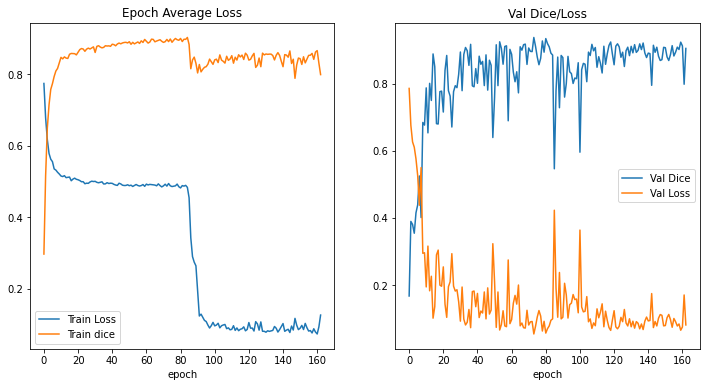

In [6]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(xloss, yloss, label='Train Loss')
plt.plot(xtrain_dice, ytrain_dice, label='Train dice')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(xdice, ydice, label='Val Dice')
plt.subplot(1,2,2)
plt.title("Val Dice/Loss")
plt.xlabel("epoch")
plt.plot(xval_loss, yval_loss, label='Val Loss')
plt.legend()
plt.show()

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0")
print(device)

cuda:0


In [13]:
DATA_DIR = config["test_dir"]
# Set randomness
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])
# Load data
images = sorted(glob.glob(os.path.join(DATA_DIR, "*.nii.gz")))
images = images[:2]
val_loader = val_dataloader(config, images)

# Hyperparams
# N_SAMPLE = config["sample_size"]
LR = config["lr"]
EPOCHS = config["epochs"]
VAL_INTERVAL = config["val_interval"]  # Interval at which to compute validation metrics
NUM_CLASSES = 6
LABEL_SHAPE = (512, 512, 320)  # All labels have this shape, but input shapes vary

# Initialize Model, Loss, and Optimizer
set_determinism(seed=config["random_seed"])
device = torch.device("cuda:0")
model = unet512(NUM_CLASSES).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

Validation sample size: 2


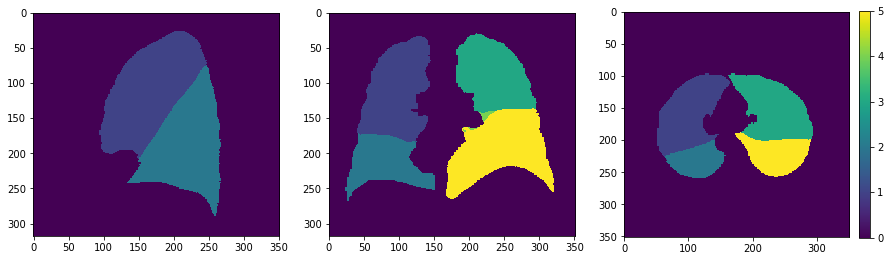

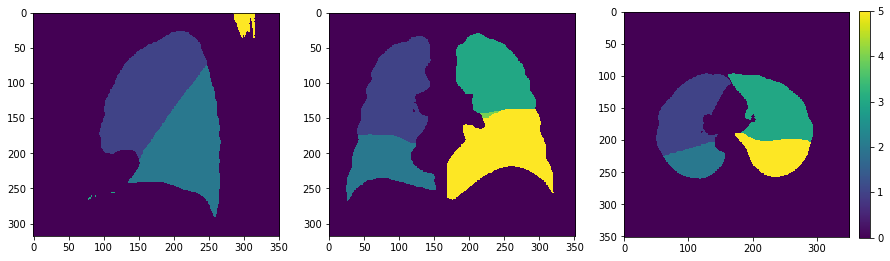

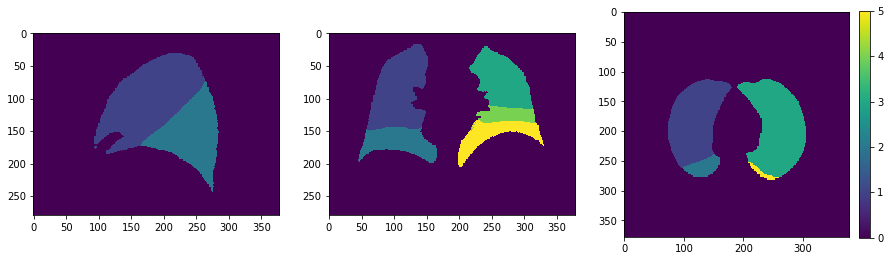

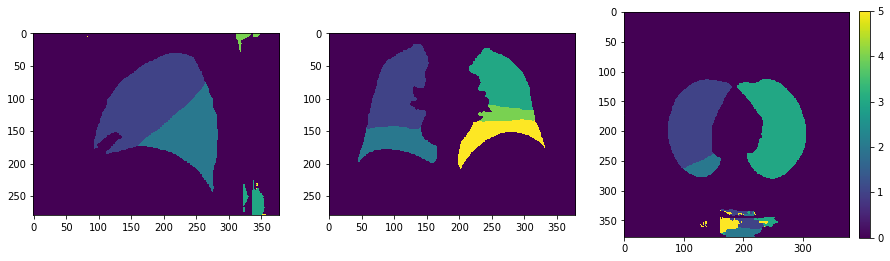

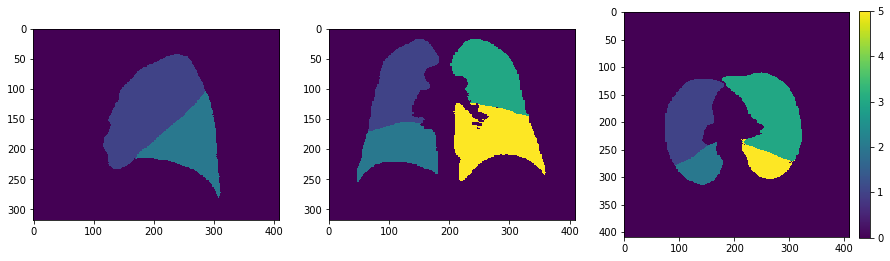

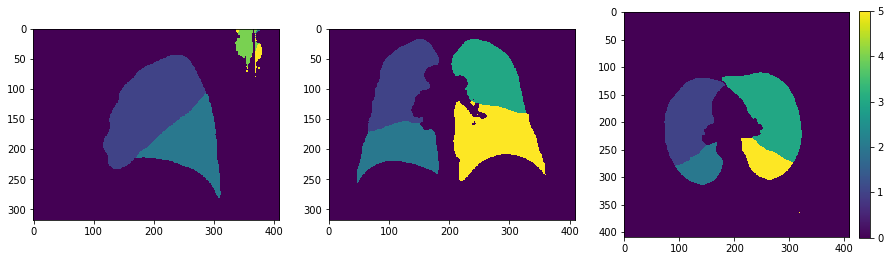

In [17]:
# Inspect recent epochs
best_model_path= os.path.join(config['model_dir'], config_id, f'{config_id}_epoch73_best_model.pth')
model.load_state_dict(torch.load(best_model_path))
model.eval()
examples = []

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i >= 3:
            break
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        np_img = val_data["image"][0,0,:,:,:].detach().cpu().numpy()
        np_label = val_data["label"][0,0,:,:,:].detach().cpu().numpy()
        # showslice(np_img, 200, 200,200, is_gray=True)
        showslice(np_label, 100, 180, 200)
        output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        showslice(output, 100, 180,200)
        plt.show()
        examples.append((np_img, np_label, output))

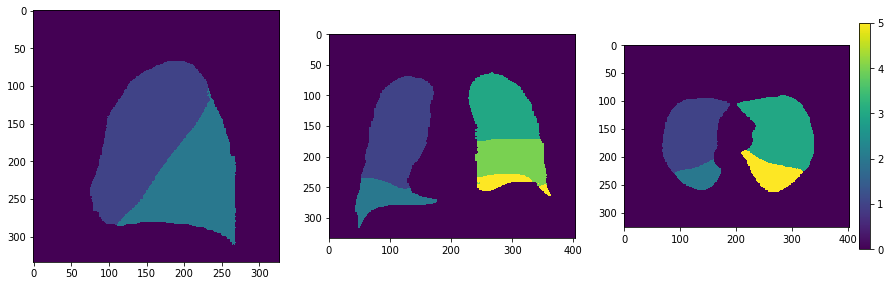

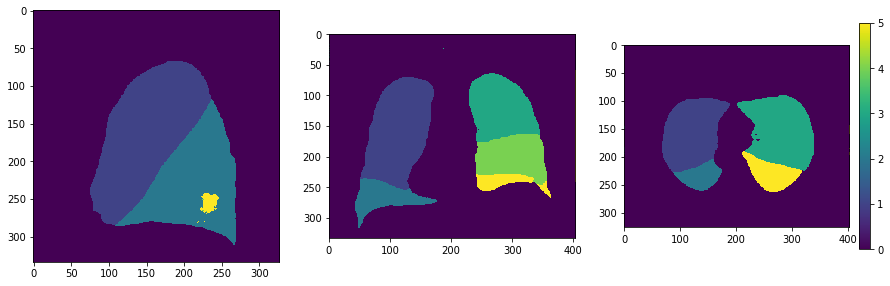

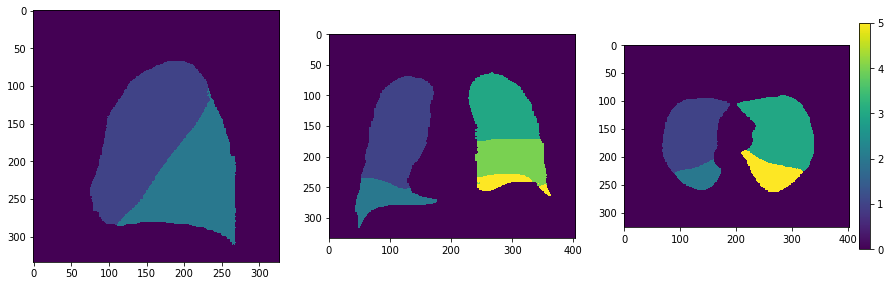

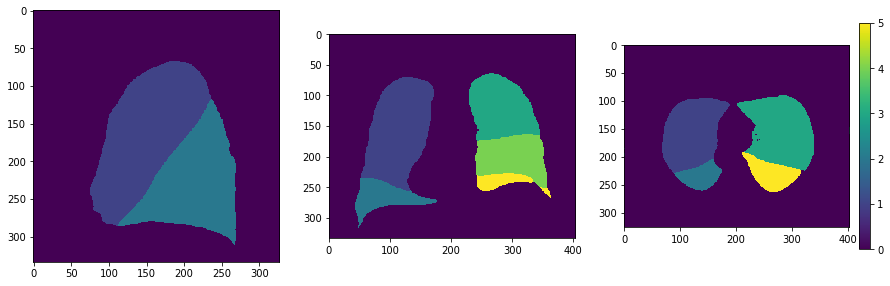

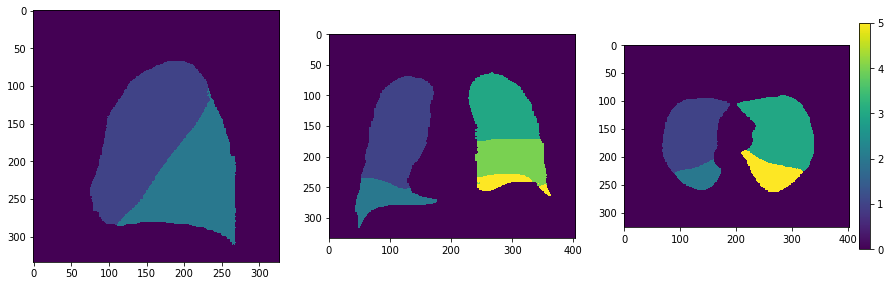

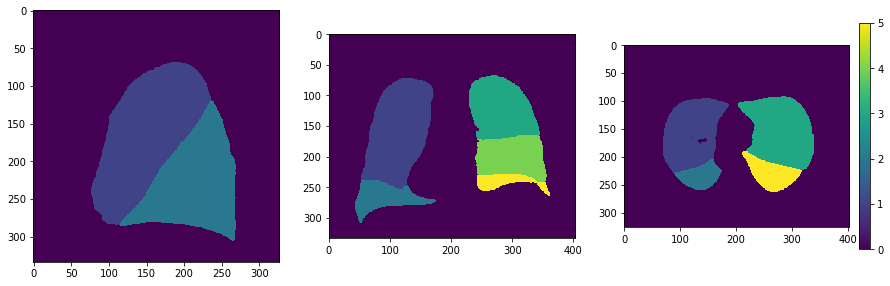

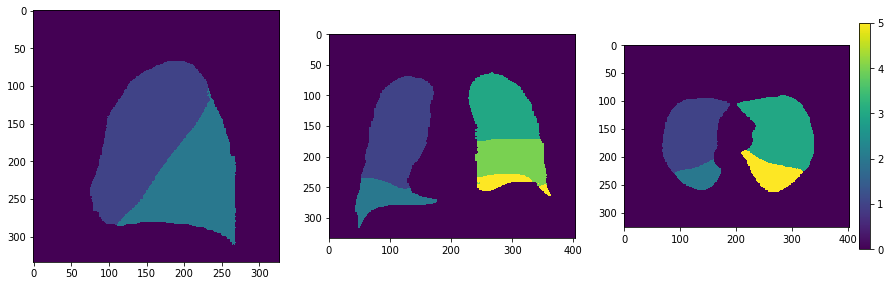

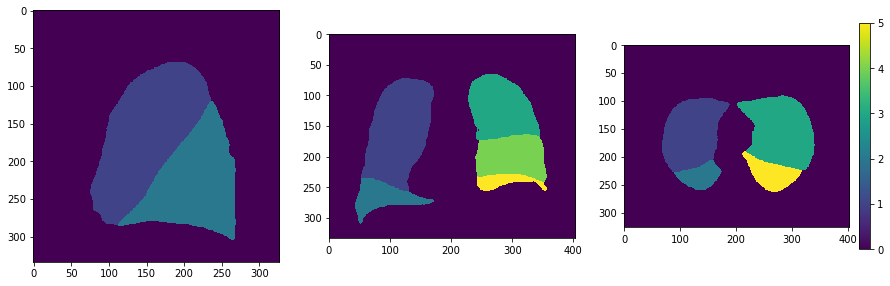

In [24]:
# epochs = ['epoch96.tar', 'epoch112.tar', 'epoch124.tar', 'epoch164.tar']
epochs = ['epoch16.tar', 'epoch20.tar', 'epoch24.tar', 'epoch28.tar']
examples = []

for epoch in epochs: 
    checkpoint_path = os.path.join(config['checkpoint_dir'], config_id, epoch)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            if i>=1:
                break
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

            np_img = val_data["image"][0,0,:,:,:].detach().cpu().numpy()
            np_label = val_data["label"][0,0,:,:,:].detach().cpu().numpy()
            # showslice(np_img, 200, 200,200, is_gray=True)
            showslice(np_label, 100, 180, 200)
            output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
            showslice(output, 100, 180, 200)
            plt.show()
            examples.append((np_img, np_label, output))


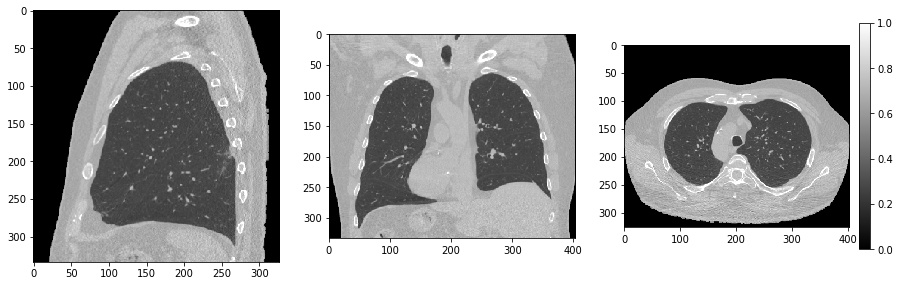

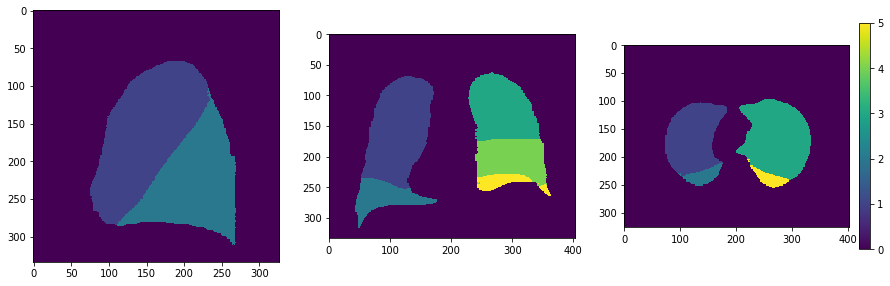

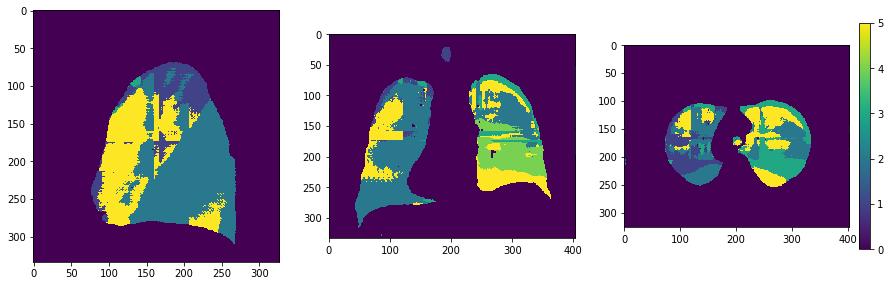

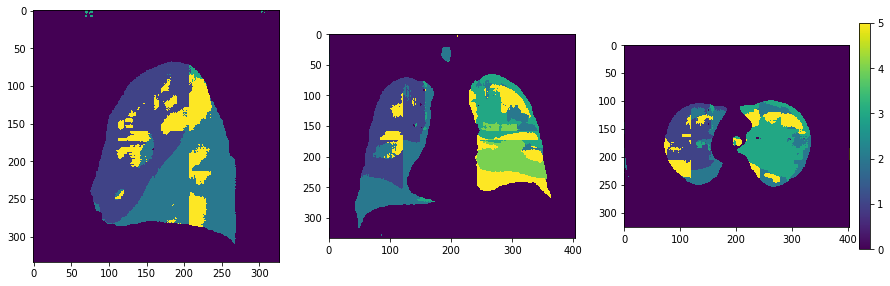

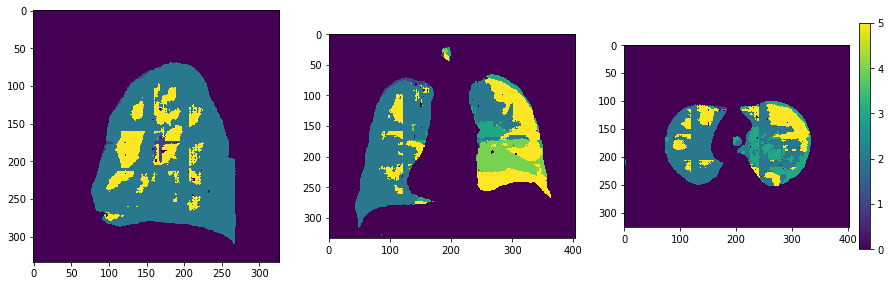

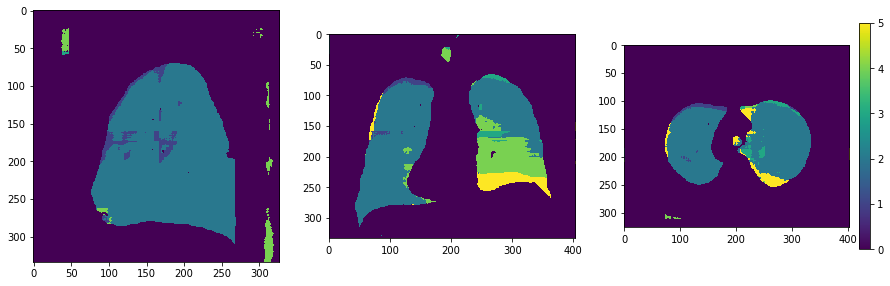

In [14]:
# epoch 96
showslice(examples[0][0], 100, 180,220, is_gray=True)
showslice(examples[0][1], 100, 180, 220)
for i in range(len(epochs)):
    showslice(examples[i][2], 100, 180,220)

In [16]:
DATA_DIR = config["data_dir"]
LABEL_DIR = config["label_dir"]
train_images = sorted(glob.glob(os.path.join(DATA_DIR, "*.nii.gz")))
train_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in train_images]
train_labels = [os.path.join(LABEL_DIR, name) for name in train_file_names]
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
val_size = int(len(train_images)*config["val_ratio"])
train_files, val_files = data_dicts[:-val_size], data_dicts[-val_size:]
# val_files
val_nii = nib.load(val_files[1]['image'])

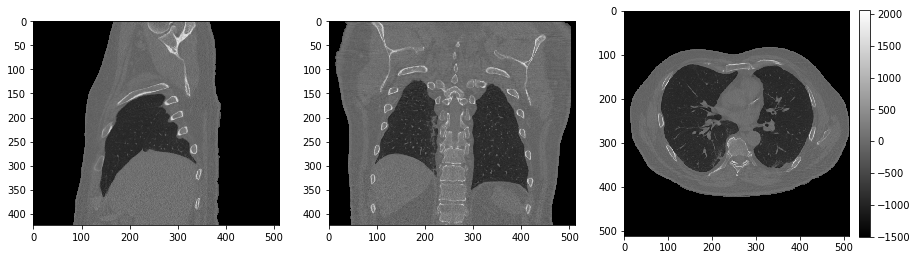

In [17]:
showslice(val_nii.get_fdata(), 100,180,200,is_gray=True)